In [1]:
import numpy as np
import pandas as pd
import mnist_reader
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.utils import shuffle
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import IncrementalPCA
from sklearn.decomposition import PCA

In [2]:
# load data
X, Y = mnist_reader.load_mnist('data', kind='train')
X_test, Y_test = mnist_reader.load_mnist('data', kind='t10k')
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, train_size=0.8, random_state=42)

# normalize data 
X_train = X_train / 255
X_val = X_val / 255

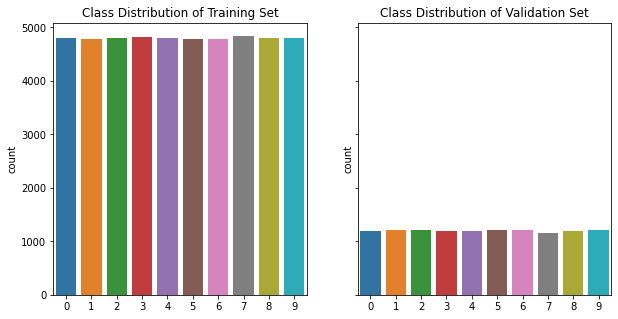

In [23]:
# plot class distributions
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 5))
sns.countplot(x=Y_train, ax=ax1)
sns.countplot(x=Y_val, ax=ax2)
ax1.set_title('Class Distribution of Training Set')
ax2.set_title('Class Distribution of Validation Set')
plt.show()

In [44]:
def accuracy(y_true, y_hat):
    accuracy = 100 * accuracy_score(y_true, y_hat)
    return accuracy

def svm_classify(hp, X_train, X_val, C=1.0, kernel='rbf', gamma='scale'):
    svm = SVC(C=C, kernel=kernel, gamma=gamma)
    start_time = time.time() # start time
    svm.fit(X_train, Y_train) # train model
    tr_time = time.time() - start_time # end time
    pred_tr = svm.predict(X_train)
    pred_val = svm.predict(X_val) 
    acc_tr = 100 * accuracy_score(Y_train, pred_tr)
    acc_val = 100 * accuracy_score(Y_val, pred_val)

    if hp == 'kernel': 
        print('Training Accuracy, %s kernel:  %.4f' %(kernel, acc_tr))
        print('Validation Accuracy, %s kernel:  %.4f' %(kernel, acc_val))
        print('Training time: --- %s seconds --- \n' % (tr_time))
    elif hp == 'C':
        print('Training Accuracy, C=%s:  %.4f' %(str(c), acc_tr))
        print('Validation Accuracy, C=%s:  %.4f' %(str(c), acc_val))
        print('Training time: --- %s seconds --- \n' % (tr_time))
    elif hp == 'gamma':
        print('Training Accuracy, gamma=%s:  %.4f' %(str(gamma), acc_tr))
        print('Validation Accuracy, gamma=%s:  %.4f' %(str(gamma), acc_val))
        print('Training time: --- %s seconds --- \n' % (tr_time))
        
    return acc_tr, acc_val


In [9]:
# no dimension reduction, different SVM kernels

kernels = ['linear', 'poly', 'rbf']
print('No dimension reduction \n')
for kernel in kernels:    
    svm = SVC(kernel=kernel, gamma='scale')
    start_time = time.time()
    svm.fit(X_train, Y_train)
    tr_time = time.time() - start_time
    pred_tr = svm.predict(X_train)
    pred_val = svm.predict(X_val) 
    print('Training Accuracy, %s kernel: %f' %(kernel, accuracy(Y_train, pred_tr)))
    print('Validation Accuracy, %s kernel: %f' %(kernel, accuracy(Y_val, pred_val)))
    print('Training time: --- %s seconds --- \n' % (tr_time))

No dimension reduction 

Accuracy, linear kernel: 85.375000
Training time: --- 299.4986653327942 seconds --- 

Accuracy, poly kernel: 86.841667
Training time: --- 342.0565276145935 seconds --- 

Accuracy, rbf kernel: 88.941667
Training time: --- 280.4582862854004 seconds --- 



Text(0, 0.5, 'cumulative explained variance')

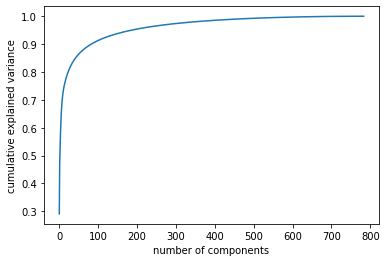

In [6]:
# find n_components that account for 95% of explained variance

pca = PCA()
pca.fit(X_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [5]:
# dimension reduction using PCA, different kernels

pca = PCA(n_components=200)
pca.fit(X_train) 
pca_tr = pca.transform(X_train)
pca_val = pca.transform(X_val)

kernels = ['linear', 'poly', 'rbf']
print('Dimension reduction using PCA \n')
for k in kernels:    
    acc_tr, acc_val = svm_classify('kernel', pca_tr, pca_val, kernel=k)

Dimension reduction using PCA 

Training Accuracy, linear kernel:  88.2604
Validation Accuracy, linear kernel:  85.9917
Training time: --- 105.6446533203125 seconds --- 

Training Accuracy, poly kernel:  91.3750
Validation Accuracy, poly kernel:  88.5500
Training time: --- 107.7330687046051 seconds --- 

Training Accuracy, rbf kernel:  91.5312
Validation Accuracy, rbf kernel:  89.4333
Training time: --- 90.88754034042358 seconds --- 



In [69]:
# compare C values for SVM with PCA dimensionality reduction

print('rbf kernel \n')

results_tr = []
results_val = []
Cs = [0.1, 1, 10, 25, 50, 100]
for c in Cs:
    acc_tr_c, acc_val_c = svm_classify('C', pca_tr, pca_val, C=c)
    results_tr.append(acc_tr_c)
    results_val.append(acc_val_c)

rbf kernel 

Training Accuracy, C=0.1:  86.2000
Validation Accuracy, C=0.1:  85.6333
Training time: --- 146.74438738822937 seconds --- 

Training Accuracy, C=1:  91.5979
Validation Accuracy, C=1:  89.4417
Training time: --- 90.94034910202026 seconds --- 

Training Accuracy, C=10:  97.2583
Validation Accuracy, C=10:  90.4583
Training time: --- 83.89043474197388 seconds --- 

Training Accuracy, C=25:  99.0604
Validation Accuracy, C=25:  90.3417
Training time: --- 86.0680661201477 seconds --- 

Training Accuracy, C=50:  99.6917
Validation Accuracy, C=50:  90.1750
Training time: --- 87.75179982185364 seconds --- 

Training Accuracy, C=100:  99.9542
Validation Accuracy, C=100:  90.0250
Training time: --- 88.18928122520447 seconds --- 



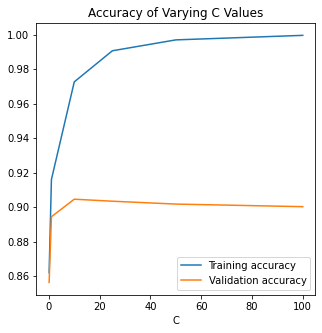

In [75]:
fig = plt.figure(figsize=(5, 5))
plt.plot(Cs, np.asarray(results_tr)/100, label='Training accuracy')
plt.plot(Cs, np.asarray(results_val)/100, label='Validation accuracy')
plt.legend()
plt.title('Accuracy of Varying C Values')
plt.xlabel('C')
#plt.savefig('c_accuracy.png')
plt.show()

In [77]:
# compare gamma values for SVM with PCA dimensionality reduction

results_tr = []
results_val = []
gammas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

for g in gammas:
    acc_tr_gamma, acc_val_gamma = svm_classify('gamma', pca_tr, pca_val, C=10, gamma=g)
    results_tr.append(acc_tr_gamma)
    results_val.append(acc_val_gamma)

Training Accuracy, gamma=1e-05:  79.0312
Validation Accuracy, gamma=1e-05:  78.6000
Training time: --- 247.69706106185913 seconds --- 

Training Accuracy, gamma=0.0001:  84.6917
Validation Accuracy, gamma=0.0001:  84.2250
Training time: --- 126.72783398628235 seconds --- 

Training Accuracy, gamma=0.001:  88.2708
Validation Accuracy, gamma=0.001:  87.2167
Training time: --- 83.55698585510254 seconds --- 

Training Accuracy, gamma=0.01:  95.4208
Validation Accuracy, gamma=0.01:  90.2167
Training time: --- 72.72080540657043 seconds --- 

Training Accuracy, gamma=0.1:  100.0000
Validation Accuracy, gamma=0.1:  89.4750
Training time: --- 395.14742064476013 seconds --- 



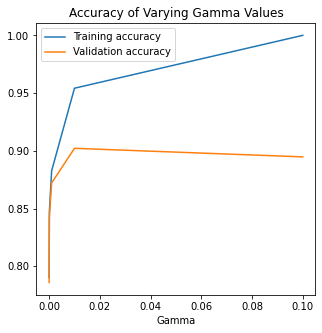

In [79]:
fig = plt.figure(figsize=(5, 5))
plt.plot(gammas, np.asarray(results_tr)/100, label='Training accuracy')
plt.plot(gammas, np.asarray(results_val)/100, label='Validation accuracy')
plt.legend()
plt.title('Accuracy of Varying Gamma Values')
plt.xlabel('Gamma')
#plt.savefig('gamma_accuracy.png')
plt.show()

Text(0, 0.5, 'cumulative explained variance')

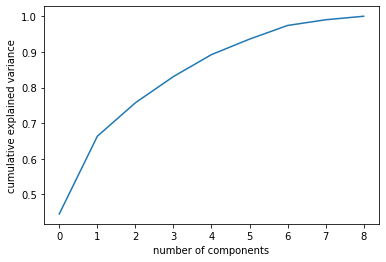

In [29]:
lda = LDA(n_components=9)
lda.fit(X_train, Y_train)
plt.plot(np.cumsum(lda.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [45]:
# dimension reduction using LDA, different kernels

lda = LDA(n_components=9)
lda.fit(X_train, Y_train)
lda_tr = lda.transform(X_train)
lda_val = lda.transform(X_val)

print('Dimension reduction using LDA \n')

kernels = ['linear', 'poly', 'rbf']
for k in kernels:    
    acc_tr, acc_val = svm_classify('kernel', lda_tr, lda_val, kernel=k)

Dimension reduction using LDA 

Training Accuracy, linear kernel:  84.4625
Validation Accuracy, linear kernel:  83.4667
Training time: --- 10.696569919586182 seconds --- 

Training Accuracy, poly kernel:  84.5208
Validation Accuracy, poly kernel:  83.2833
Training time: --- 7.405343770980835 seconds --- 

Training Accuracy, rbf kernel:  85.2437
Validation Accuracy, rbf kernel:  84.2000
Training time: --- 7.488542079925537 seconds --- 



In [8]:
# find best parameters

tune_params = [{'kernel': ['rbf'], 'C': [0.1, 1.0, 10, 25, 50, 100], 'gamma': [1e-4, 1e-3, 1e-2, 'auto', 'scale']}]

pca = PCA(n_components=200)
pca.fit(X) 
pca_tr = pca.transform(X)
pca_val = pca.transform(X_test)

print('# Tuning hyperparameters for SVM with PCA dimensionality reduction \n')

search = GridSearchCV(SVC(), tune_params, scoring='accuracy', n_jobs=2, cv=5, verbose=2)
search.fit(pca_tr, Y)

# Tuning hyperparameters for SVM with PCA dimensionality reduction 

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed: 487.5min
[Parallel(n_jobs=2)]: Done 150 out of 150 | elapsed: 1447.9min finished


GridSearchCV(cv=5, estimator=SVC(), n_jobs=2,
             param_grid=[{'C': [0.1, 1.0, 10, 25, 50, 100],
                          'gamma': [0.0001, 0.001, 0.01, 'auto', 'scale'],
                          'kernel': ['rbf']}],
             scoring='accuracy', verbose=1)

In [9]:
print("Mean scores by parameter set:\n")
for mean, params in zip(search.cv_results_['mean_test_score'], search.cv_results_['params']):
    print("%0.4f for %r" % (mean, params))
print()    
print("Best hyperparameters:\n")
print(search.best_params_)

Mean scores by parameter set:

0.1006 for {'C': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.1652 for {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}
0.1011 for {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
0.1070 for {'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}
0.8568 for {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
0.1032 for {'C': 1.0, 'gamma': 0.0001, 'kernel': 'rbf'}
0.1007 for {'C': 1.0, 'gamma': 0.001, 'kernel': 'rbf'}
0.1007 for {'C': 1.0, 'gamma': 0.01, 'kernel': 'rbf'}
0.1028 for {'C': 1.0, 'gamma': 'auto', 'kernel': 'rbf'}
0.8939 for {'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}
0.1050 for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.1008 for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.1008 for {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
0.1029 for {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
0.9065 for {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
0.1050 for {'C': 25, 'gamma': 0.0001, 'kernel': 'rbf'}
0.1008 for {'C': 25, 'gamma': 0.001, 'kernel': 'rbf'}
0.1008 for {'C': 25, 'gamma': 0

In [13]:
final_svm = SVC(C=10, kernel='rbf', gamma='scale')
start_time = time.time()
final_svm.fit(pca_tr, Y)
tr_time = time.time() - start_time
predictions = final_svm.predict(pca_val)
accuracy = 100 * accuracy_score(Y_test, predictions)

print('Accuracy of tuned model: %.4f' %(accuracy))
print('Training time: --- %.4f seconds ---' %(tr_time))

Accuracy of tuned model: 90.2500
Training time: --- 120.0483 seconds ---


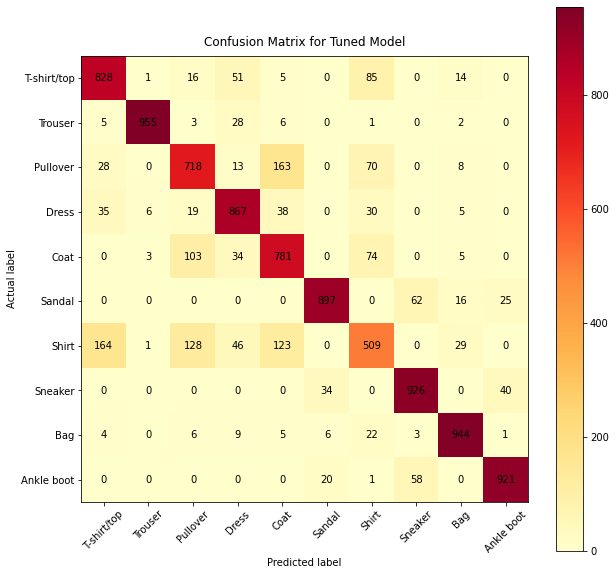

In [40]:
cm = confusion_matrix(Y_test, predictions)
plt.figure(figsize=(10, 10))
plt.title('Confusion Matrix for Tuned Model', pad=10)
tick_marks = np.arange(10)
plt.xticks(tick_marks, ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 
                        'Sneaker', 'Bag', 'Ankle boot'], rotation=45)
plt.yticks(tick_marks, ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 
                        'Sneaker', 'Bag', 'Ankle boot'])

plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.imshow(cm, cmap='YlOrRd')
plt.colorbar()

height, width = cm.shape
for x in range(width):
    for y in range(height):
        plt.annotate(str(cm[x][y]), xy=(y, x), ha='center', va='center')
        
#plt.savefig('svm_cm.png')